In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('expand_frame_repr', False) # Prevent the DataFrame from being printed across multiple lines
pd.options.display.float_format = '{:.4f}'.format # Suppress scientific notation

# 1. Import Data
First, we load the data and check it. 

In [2]:
df = pd.read_csv('../input/movies/movies.csv')
print('Number of rows: ', str(len(df.index)))
df.head()

Number of rows:  7668


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4000,927000.0000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0000,46998772.0000,Warner Bros.,146.0000
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8000,65000.0000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0000,58853106.0000,Columbia Pictures,104.0000
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7000,1200000.0000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0000,538375067.0000,Lucasfilm,124.0000
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7000,221000.0000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0000,83453539.0000,Paramount Pictures,88.0000
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3000,108000.0000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0000,39846344.0000,Orion Pictures,98.0000


# 2. Data Cleaning
We start by cleaning the data to prepare it for further analysis.

## 2.1 Missing Values
The code below checks the number and the percentage of missing data for each column in the dataset.

In [3]:
for c in df.columns:
    pct_null = np.mean(df[c].isnull()) * 100
    count_null = df[c].isnull().sum()
    print('{} - {} - {}%'.format(c, count_null, pct_null))

name - 0 - 0.0%
rating - 77 - 1.004173187271779%
genre - 0 - 0.0%
year - 0 - 0.0%
released - 2 - 0.02608242044861763%
score - 3 - 0.03912363067292645%
votes - 3 - 0.03912363067292645%
director - 0 - 0.0%
writer - 3 - 0.03912363067292645%
star - 1 - 0.013041210224308816%
country - 3 - 0.03912363067292645%
budget - 2171 - 28.31246739697444%
gross - 189 - 2.464788732394366%
company - 17 - 0.2217005738132499%
runtime - 4 - 0.05216484089723526%


For now, I chose to keep most entries with missing values, to have a higher number of observations for each variable. However, since only two films are missing the release date, we will look up the information online and fill it in to make it easier for the algorithm to convert the *release_year* (which we will extract from the *released* column) data type to integer.

In [4]:
df[df['released'].isnull()] # Films where released is null

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5728,Saw: The Final Chapter,R,Crime,2010,NaN,5.6000,93000.0000,Kevin Greutert,Patrick Melton,Tobin Bell,NaN,NaN,NaN,NaN,NaN
5730,The Wolfman,R,Drama,2010,NaN,5.8000,104000.0000,Joe Johnston,Andrew Kevin Walker,Benicio Del Toro,NaN,NaN,NaN,NaN,NaN


In [5]:
df.loc[df['name'].isin(pd.Series(['Saw: The Final Chapter'])),'released']='October 29, 2010 (United States)'
df.loc[df['name'].isin(pd.Series(['The Wolfman'])),'released']='February 12, 2010 (United States)'
print('Null values in released:', str(df['released'].isnull().sum()))

Null values in released: 0


## 2.2 Data Types
Next, let us check the data types for each column and evaluate if they are suitable for the data in the corresponding columns.

In [6]:
df.dtypes

name         object
rating       object
genre        object
year          int64
released     object
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object

Most data types are correct, and although the *votes*, *budget*, *gross* and *runtime* columns do not require decimal precision, we cannot change the data type from float to integer due to the presence of null values, so we will keep them as they are, as it does not affect the data.

## 2.4 Check Duplicates

Let us check that the dataset does not contain any duplicates and drop duplicate values, to ensure the accuracy of our further analysis.

In [7]:
df.drop_duplicates()
print('Number of rows after dropping duplicates:', str(len(df)))

Number of rows after dropping duplicates: 7668


There were no duplicate entries in the dataset, so the number of rows remained the same.

## 2.3 Checking Values
At first glance, the release year matches the year in the full release date column in the first five rows. Let us check if it is the case in all instances. 

In [8]:
df['year_check'] = np.where((df['released'].str.split(', ').str[-1].astype(str).str[:4] == df['year'].astype(str)), True, False)
print(df['year_check'].value_counts())
print(df[['name', 'year', 'released','year_check']][~df['year_check']][:20])

True     6323
False    1345
Name: year_check, dtype: int64
                                 name  year                           released  year_check
8                         Superman II  1980      June 19, 1981 (United States)       False
11             The Gods Must Be Crazy  1980   October 26, 1984 (United States)       False
21                      Heaven's Gate  1980     April 24, 1981 (United States)       False
33   Cattle Annie and Little Britches  1980     April 24, 1981 (United States)       False
40           The Watcher in the Woods  1980    October 9, 1981 (United States)       False
49                 Lion of the Desert  1980               May 16, 1981 (Japan)       False
54                      City of Women  1980      April 8, 1981 (United States)       False
59                          Hangar 18  1980           March 13, 1981 (Ireland)       False
62                       It's My Turn  1980       February 5, 1981 (Argentina)       False
78                            B

It turned out that the year in the *year* column is not the same as the actual year in the *released* column in 1347 records. We also printed 20 first rows where the value is "False" as an example to check that the code worked correctly.

To fix this issue, we will create a new column with the correct year by extracting the value from the *released* column and print the first 10 rows of the result.

In [9]:
df['release_year'] = df['released'].str.replace('\D+', '').str[-4:].astype('int64')
print(df[['name', 'released', 'release_year']][:10])

                                             name                           released  release_year
0                                     The Shining      June 13, 1980 (United States)          1980
1                                 The Blue Lagoon       July 2, 1980 (United States)          1980
2  Star Wars: Episode V - The Empire Strikes Back      June 20, 1980 (United States)          1980
3                                       Airplane!       July 2, 1980 (United States)          1980
4                                      Caddyshack      July 25, 1980 (United States)          1980
5                                 Friday the 13th        May 9, 1980 (United States)          1980
6                              The Blues Brothers      June 20, 1980 (United States)          1980
7                                     Raging Bull  December 19, 1980 (United States)          1980
8                                     Superman II      June 19, 1981 (United States)          1981
9         

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


Next, we will generate summary statistics for numeric columns to further explore the data, and clean it if unexpected patterns emerge.

In [10]:
print('Mean values:')
print(df[['release_year', 'score', 'votes', 'budget', 'gross', 'runtime']].mean())

print('\nMinimum values:')
print(df[['release_year', 'score', 'votes', 'budget', 'gross', 'runtime']].min())

print('\nMaximum values:')
print(df[['release_year', 'score', 'votes', 'budget', 'gross', 'runtime']].max())

Mean values:
release_year       2000.6265
score                 6.3904
votes             88108.5048
budget         35589876.1927
gross          78500541.0178
runtime             107.2616
dtype: float64

Minimum values:
release_year   1980.0000
score             1.9000
votes             7.0000
budget         3000.0000
gross           309.0000
runtime          55.0000
dtype: float64

Maximum values:
release_year         2020.0000
score                   9.3000
votes             2400000.0000
budget          356000000.0000
gross          2847246203.0000
runtime               366.0000
dtype: float64


Based on the output above, the data covers years between 1980 and 2020, the scores range between 1 and 10, and an average film runs 107 minutes. There is a large discrepancy between the largest and smallest votes, gross and budget, but that could be attributed to the popularity of the respective films. The longest runtime is 366 minutes, which is roughly 6 hours, so we will check which film generated this value, as well as the other films with the highest duration:

In [11]:
print(df[['name', 'year', 'runtime']].sort_values(by=['runtime'], ascending=False)[:5])

                            name  year  runtime
4396           The Best of Youth  2003 366.0000
1218               Little Dorrit  1987 357.0000
2280                  Gettysburg  1993 271.0000
2888                      Hamlet  1996 242.0000
1868  The Beautiful Troublemaker  1991 238.0000


According to IMDb, the duration of *The Best of Youth (2003)* is indeed 6 hours 6 minutes. The runtime of the top 5 longest films matches, too, so the data looks correct.

Next, we check the columns with string values.

In [12]:
print('rating')
print(np.sort(pd.unique(df['rating'].astype(str).values)))
print('\ngenre')
print(np.sort(pd.unique(df['genre'].astype(str).values)))
print('\ndirector')
print(np.sort(pd.unique(df['director'].astype(str).values)))
print('\ncountry')
print(np.sort(pd.unique(df['country'].astype(str).values)))
print('\ncompany')
print(np.sort(pd.unique(df['company'].astype(str).values))[:20])
print(np.sort(pd.unique(df['company'].astype(str).values))[-20:])

rating
['Approved' 'G' 'NC-17' 'Not Rated' 'PG' 'PG-13' 'R' 'TV-14' 'TV-MA'
 'TV-PG' 'Unrated' 'X' 'nan']

genre
['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Sport' 'Thriller' 'Western']

director
['A.R. Murugadoss' 'Aamir Khan' 'Aaron Blaise' ... 'Élie Chouraqui'
 'Éric Rohmer' 'Éva Gárdos']

country
['Argentina' 'Aruba' 'Australia' 'Austria' 'Belgium' 'Brazil' 'Canada'
 'Chile' 'China' 'Colombia' 'Czech Republic' 'Denmark'
 'Federal Republic of Yugoslavia' 'Finland' 'France' 'Germany' 'Greece'
 'Hong Kong' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Ireland'
 'Israel' 'Italy' 'Jamaica' 'Japan' 'Kenya' 'Lebanon' 'Libya' 'Malta'
 'Mexico' 'Netherlands' 'New Zealand' 'Norway' 'Panama' 'Philippines'
 'Poland' 'Portugal' 'Republic of Macedonia' 'Romania' 'Russia' 'Serbia'
 'South Africa' 'South Korea' 'Soviet Union' 'Spain' 'Sweden'
 'Switzerland' 'Taiwan' 'Thailand' 'Turk

Most data looks good and clean, however there is an inconsistency in the *rating* column: a film that is not rated is the same as an unrated film, so we shall unify the classifications.

In [13]:
df.loc[df['rating'].astype(str).str.contains('Not Rated'), 'rating'] = 'Unrated'
print('rating')
print(np.sort(pd.unique(df['rating'].astype(str).values)))

rating
['Approved' 'G' 'NC-17' 'PG' 'PG-13' 'R' 'TV-14' 'TV-MA' 'TV-PG' 'Unrated'
 'X' 'nan']


Now that we have cleaned the data, we are ready to proceed with data analysis.

# 3. Data Analysis

Let us check which variables have the highest correlation with the films' *gross*. The starting hypothesis is that the films with a high *budget* and a high *score* tend to have a higher *gross*. To check whether this assumption is correct, we will generate a correlation matrix.

[Text(0.5, 1.0, 'Correlation Matrix')]

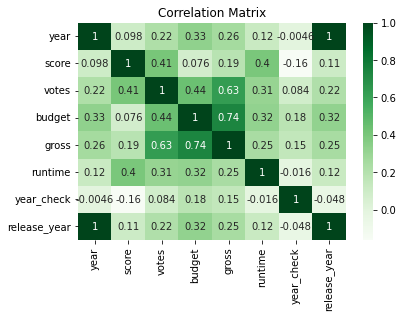

In [14]:
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='Greens').set(title='Correlation Matrix')

*Budget* and *votes* have the strongest positive correlation with *gross* (0.74 and 0.63, respectively). This relationship is understandable: for a project to be successful, it is expected that the revenue the project generates is enough to cover the money invested in the project, and generate profit. High grossing films have a larger audience, which will result in more people reviewing the film, hence higher *votes*. Based on the data, the film's success is rarely indicative of its quality based on *score*, however this is also affected by the number of people voting. As lower grossing films have fewer *votes*, the sample size is smaller, which can lead to biased scores. 

We can visualise the relationships using scatter plots

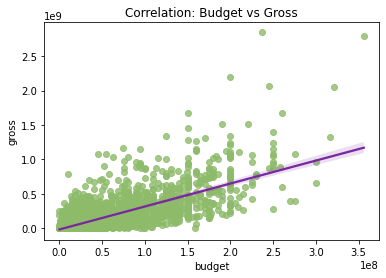

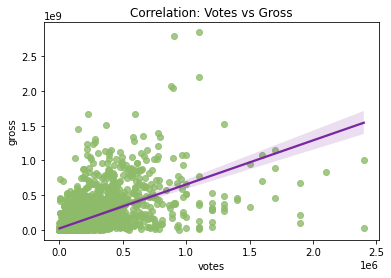

In [15]:
sns.regplot(data=df, x='budget', y='gross', scatter_kws={"color": "#8dbb69"}, line_kws={"color": "#7928a1"}).set(title='Correlation: Budget vs Gross')
plt.show()

sns.regplot(data=df, x='votes', y='gross', scatter_kws={"color": "#8dbb69"}, line_kws={"color": "#7928a1"}).set(title='Correlation: Votes vs Gross')
plt.show()

The scatter plots further confirm the positive relationship between *gross* and the two variables, however it is evident that there are outliers in the data, which affects the Pearson correlation coefficient, making it not the most reliable method to analyse this data. It is beyond the scope of this project, but to gain a more comprehensive understanding, using other methods of analysis is recommended.

We can use a box plot to see the outliers more clearly.

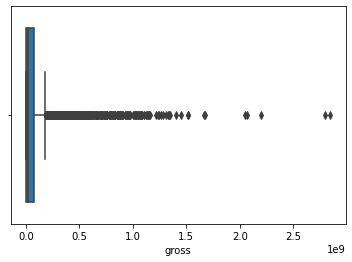

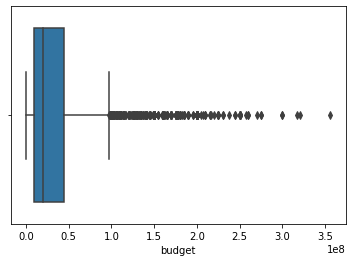

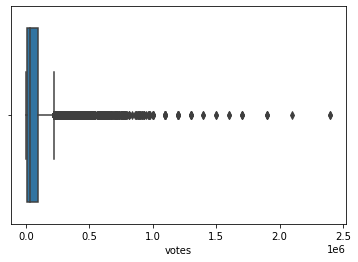

In [16]:
sns.boxplot(x=df['gross'])
plt.show()
sns.boxplot(x=df["budget"])
plt.show()
sns.boxplot(x=df["votes"])
plt.show()

Next, it will be interesting to look at trends over time. We will look whether there were any changes in *budget*, *gross*, and *scores* between 1980-2020. which is the time period that this dataset covers.

We start by aggregating the data and grouping it by *release_year*.

In [17]:
df_aggregated = df.groupby(df['release_year']).agg({'budget': ['sum'], 'gross': ['sum'], 'score': ['mean'], 'name': ['count']})

df_aggregated.head() # Check that the data was aggregated correctly

,budget,gross,score,name
,sum,sum,mean,count
release_year,,,,
1980,411750000.0000,2329467495.0000,6.2650,80
1981,721600000.0000,2253568643.0000,6.2311,103
1982,872285000.0000,3440552520.0000,6.2922,128
1983,900610562.0000,2707175581.0000,6.0800,145
1984,1137476000.0000,3631931624.0000,6.1510,157


Next, we plot the time series data of total *budget* and *gross* per year on a line chart to visualise the trend.

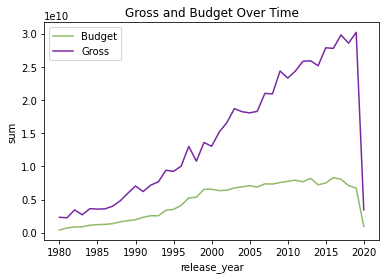

In [18]:
sns.lineplot(data=df_aggregated, x='release_year', y=df_aggregated['budget']['sum'], color='#8dbb69')
sns.lineplot(data=df_aggregated, x='release_year', y=df_aggregated['gross']['sum'], color="#7928a1")
plt.title('Gross and Budget Over Time')
plt.legend(labels=["Budget","Gross"])
plt.show()

Since *gross* can be significantly higher than *budget*, especially in the latter years, the actual change in the *budget* can be difficult to see. We can adjust the scale by using logarithmic values of the variables.

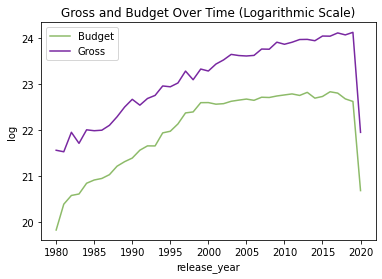

In [19]:
log_budget = np.log(df_aggregated['budget']['sum'])
log_gross = np.log(df_aggregated['gross']['sum'])

sns.lineplot(data=df_aggregated, x='release_year', y=log_budget, color='#8dbb69')
sns.lineplot(data=df_aggregated, x='release_year', y=log_gross, color="#7928a1")
plt.ylabel('log')
plt.legend(labels=["Budget","Gross"])
plt.title('Gross and Budget Over Time (Logarithmic Scale)')
plt.show()

The graph above illustrates that the film industry experienced consistent growth for the most part, however it faced a sharp decline in both the *budget* and the *gross* in 2020. This was likely related to the COVID-19 pandemic, which saw fewer films being made and cinemas being closed or only allowing 50% of the audience to prevent the spread of the virus.

In fact, we can check the total number of films released each year by plotting it on a line chart, too.

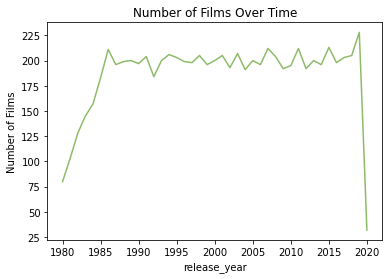

In [20]:
sns.lineplot(data=df_aggregated, x='release_year', y=df_aggregated['name']['count'], color='#8dbb69')
plt.ylabel('Number of Films')
plt.title('Number of Films Over Time')
plt.show()

Indeed, there was a sharp decline in the number of films released in 2020.

Next, we will see if the quality of films increased over time, using the average *score* each year as the measurement.

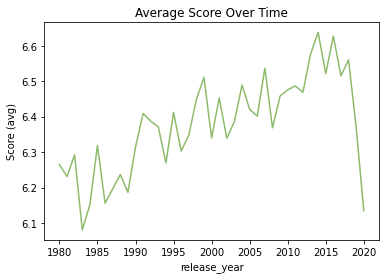

In [21]:
sns.lineplot(data=df_aggregated, x='release_year', y=df_aggregated['score']['mean'], color='#8dbb69')
plt.ylabel('Score (avg)')
plt.title('Average Score Over Time')
plt.show()

There is much more fluctuation on this graph, although the overall trend was positive until a steep decline in 2020. So, not only were there fewer films released during the first year of the pandemic, but their quality (or at least the viewers' satisfaction) was lower on average.

The data of the subsquent years will be interesting to see when it becomes available. Time will tell how long it will take for the film industry to recover and reach the pre-covid numbers. With overall costs rising across the board, it might be a difficult journey as the costs of film production likely increased, and the spending habits have changed.